In [5]:
from sys import path
path.append('../../')
from kooplearn.estimators import ReducedRank, PrincipalComponent
from kooplearn.kernels import RBF, Matern

from Logistic import LogisticMap
from Lorenz63 import Lorenz63

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})

In [2]:
def time_fn_execution(f, args, num_repetitions):
    times = np.zeros(num_repetitions)
    for rep_idx in range(num_repetitions):
        _start = perf_counter()
        f(*args) #time it
        _stop = perf_counter()
        times[rep_idx] = _stop - _start
    return times

def benchmark(map, sample_size, params, num_repetitions, sample_kwargs = {}, solvers = ['full', 'randomized']):
    x, y = map.sample(size=sample_size, **sample_kwargs)
    x = (x - x.mean(axis=0)) / x.std(axis=0)
    y = (y - y.mean(axis=0)) / y.std(axis=0)
    times = np.zeros((len(solvers), num_repetitions))
    for solver_idx, svd_solver in enumerate(solvers):
        estimator = ReducedRank(**params, svd_solver=svd_solver)
        times[solver_idx,:] = time_fn_execution(estimator.fit, (x,y), num_repetitions)
    return times

In [3]:
#sample_sizes = [500, 1000, 2000, 3000, 5000, 7500, 10000]
sample_sizes = [100, 200, 300, 400, 500, 750, 1000, 2000]
solvers = ['full', 'randomized', 'arnoldi']
means = np.zeros((len(solvers), len(sample_sizes)))
stds = np.zeros((len(solvers), len(sample_sizes)))

num_repetitions = 3


#Logistic Map
kernel = RBF(length_scale=0.5)
params = {
    'kernel': kernel,
    'backend': 'numpy',
    'rank': 3,
    'tikhonov_reg': 1e-6,
    'n_oversamples': 10,
    'iterated_power': 2
}
map = LogisticMap(N = 20)

Init: Transfer matrix: 100%|██████████| 21/21 [00:00<00:00, 25.28it/s]


In [4]:
for sample_idx, sample_size in tqdm(enumerate(sample_sizes), total=len(sample_sizes)):
    times = benchmark(map, sample_size, params, num_repetitions, solvers=solvers)
    means[:, sample_idx] = times.mean(axis=1)
    stds[:, sample_idx] = times.std(axis=1)

100%|██████████| 8/8 [01:15<00:00,  9.44s/it]


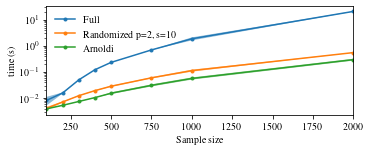

In [8]:
fig_width = 5.5 #Inches
fig_height = 2 #Inches

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
for solver_idx, solver in enumerate(solvers):
    if solver == 'randomized':
        label = solver.capitalize() + f" p={params['iterated_power']}, s={params['n_oversamples']}"
    else:
        label = solver.capitalize()
    ax.plot(sample_sizes, means[solver_idx], '.-', label=label)
    ax.fill_between(sample_sizes, (means - stds)[solver_idx], (means + stds)[solver_idx], alpha=0.5)
ax.set_ylabel("time (s)")
ax.set_xlabel("Sample size")
ax.set_yscale('log')
ax.set_xmargin(0)
plt.legend(frameon=False, loc='upper left')
plt.savefig("figs/randomizedSVD_benchmarks.pdf")